Genrate section 3 results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn 
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mtick
import time
from scipy.optimize import fmin_l_bfgs_b
from scipy.optimize import minimize
import pandas as pd
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import time
np.random.seed(28)



from Basic import array, near_field_Boundary, sample_in_half_circle,Single_Noise_dB_to_std
from ML_estimator import *
from S_recovery import *
from Evaluation import *


In [2]:
filepath = 'C:/Users/73160/OneDrive/项目/project/Weekly reports/Sp_16/Section3'
#plotting setting
size=10;f=12

# Section 3

In [3]:
#Basic settings

N=10 # number of elements
lmb=2e-3 # wavelength of the signal
d=0.25*lmb # distance between 2 adjacent elements
flag_plot=0

arr_dim=d*(N-1) # dimension of the array
arr=array(N,arr_dim,0) # array elements location
R_near=near_field_Boundary(lmb,arr_dim)
arr_center=0.5*arr_dim

# generating targets
N_target=200
# targets = sample_in_half_circle(R_near,N_target)+np.array([arr_center,0])
# # print(f"True target:{targets}")
# np.savetxt(f'targets_{N_target}.txt',targets)
targets=np.loadtxt(f'targets_{N_target}.txt')
# print(targets)

## ML grid searching 

In [23]:
#main 
noise_dB = 40

true_target=targets[2]
# phase measurements
phase_obs=np.zeros(N)
phi_0=1
print(f'phase shift is {phi_0} [rad].')

position_noise_std=Single_Noise_dB_to_std(noise_dB) # noises are added in the form of position noise
print(f'noise sigma:{lmb*position_noise_std}')
noisy_target=true_target+lmb*randn(2)*position_noise_std
dist=np.array([np.linalg.norm(arr[n]-noisy_target) for n in range(N)])#distance between the elements and target
dist_true=np.array([np.linalg.norm(arr[n]-true_target) for n in range(N)])#distance between the elements and target
phase_obs=(4*np.pi/lmb*dist+phi_0)%(2*np.pi)
phase_shift=(4*np.pi/lmb*dist_true+phi_0)%(2*np.pi)
phase_true=(4*np.pi/lmb*dist_true)%(2*np.pi)
phase_true_unwrap=(4*np.pi/lmb*dist_true)


phase shift is 1 [rad].
noise sigma:2e-05


Observed and true phase

In [12]:
# #plot the phases
# plt.figure()
# plt.scatter(range(1,N+1),phase_obs,color='red',s=10)
# plt.scatter(range(1,N+1),phase_shift,color='purple',s=10)
# plt.scatter(range(1,N+1),phase_true,color='green',s=10)
# # plt.scatter(range(1,N+1),phase_true_unwrap,color='blue',s=10)
# plt.legend(['Observed','Shift','True','True unwrap'])
# # plt.title('Phase')
# plt.xlabel('Antenna')
# plt.ylabel('Phase [rad]')
# plt.savefig(filepath+'/Observed_phase.png')

searching range is x:[-0.018   0.0225],y:[0.      0.02025]
True target:[0.01428262 0.01111305]
 Estimated target:[[0.013 0.01 ]]


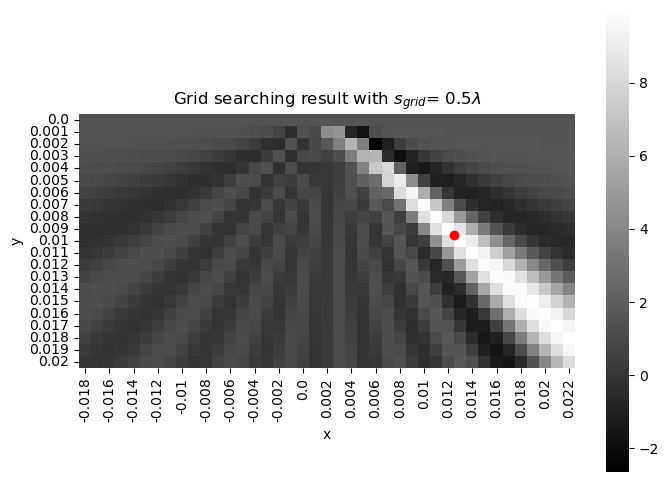

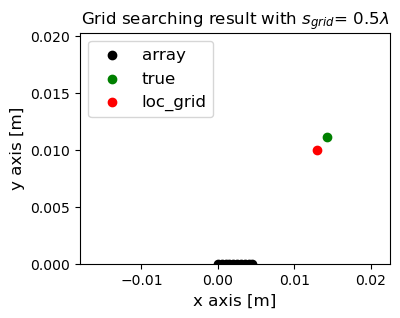

In [26]:
#ML grid searching example
#plot grid searching and compare the estimated location with the truth
grid_size = 0.5*lmb
xrange=np.array([arr_center-R_near,arr_center+R_near])
yrange=np.array([0,R_near])
print(f"searching range is x:{xrange},y:{yrange}")
ml=ML()
_,Loc_MLgrid=ml.ML_grid(xrange,yrange,phase_obs,arr,lmb,resolution = grid_size,flag_prior = False,flag_plot = True)
print(f"True target:{true_target}\n Estimated target:{Loc_MLgrid}")
plt.savefig(filepath+f'/Grid_search_noise_{noise_dB}_resol_{grid_size/lmb}lmb.png')

plt.figure(figsize=[4,3])
plt.scatter(arr[:,0],arr[:,1],color='black')
plt.scatter(true_target[0],true_target[1],color='green')
plt.scatter(Loc_MLgrid[0,0],Loc_MLgrid[0,1],color='red')
plt.title(f'Grid searching result with '+r'$s_{grid}$'+f'= {grid_size/lmb}'+r'$\lambda$',fontsize=f)
plt.legend(['array','true','loc_grid'],loc='upper left',fontsize=f)
plt.xlim([arr_center-R_near,arr_center+R_near])
plt.ylim([0,R_near])
plt.xlabel('x axis [m]',fontsize=f)
plt.ylabel('y axis [m]',fontsize=f)
plt.savefig(filepath+f'/Grid_search_noise_{noise_dB}_{grid_size/lmb}lmb_2.png')

## hierarchical ML

example

phase shift is 1 [rad].
0.01
xrange:[-0.018   0.0225],yrange:[0.      0.02025]
Estimated postions in all the iterations:[[-0.003     0.015   ]
 [-0.0005    0.0175  ]
 [ 0.00075   0.01625 ]
 [ 0.001375  0.010625]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 500x500 with 0 Axes>

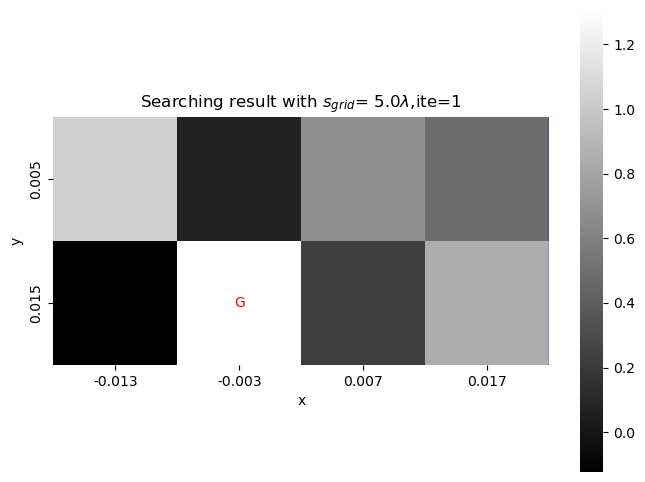

<Figure size 500x500 with 0 Axes>

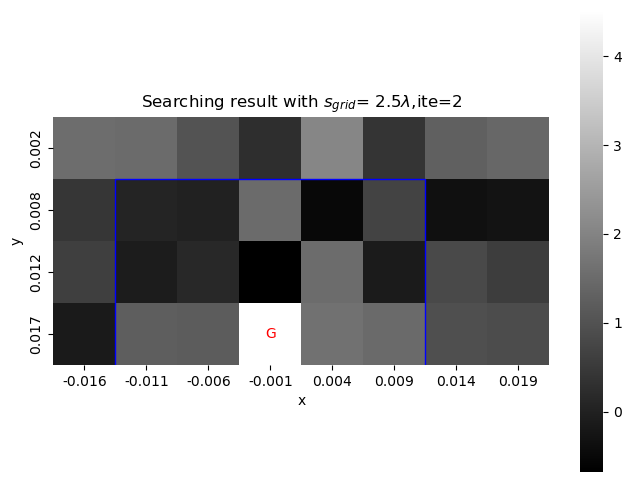

<Figure size 500x500 with 0 Axes>

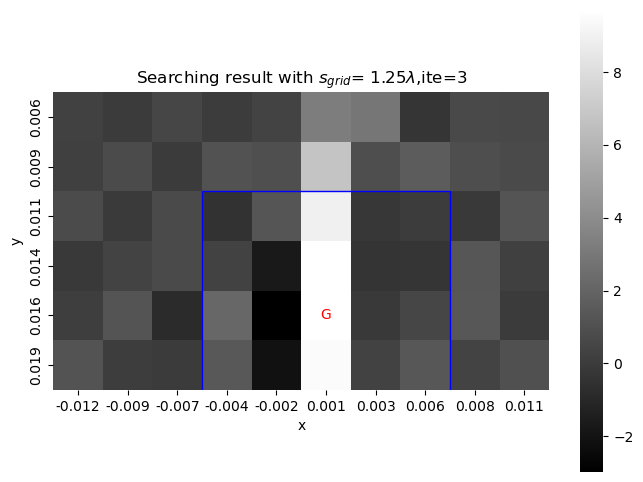

<Figure size 500x500 with 0 Axes>

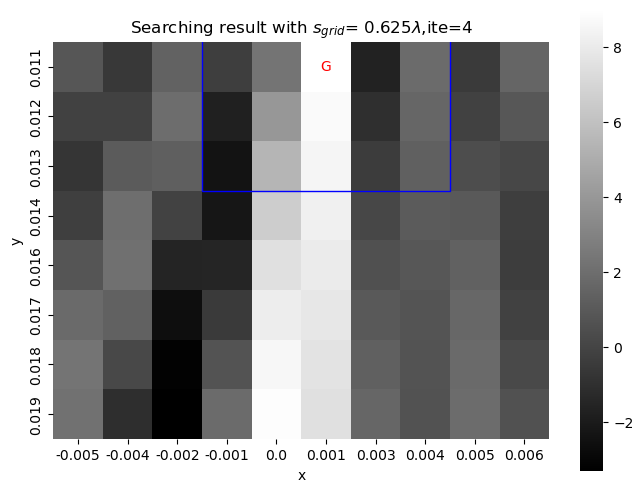

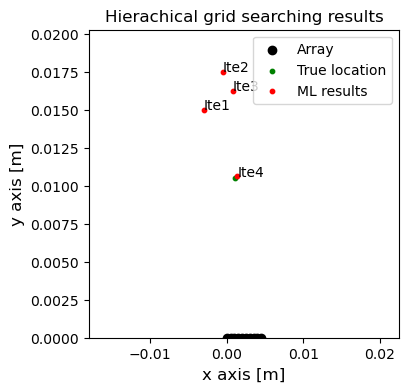

In [97]:
#main 
noise_dB = 40


true_targets=targets[3]
# phase measurements
phase_obs=np.zeros(N)
# phi_0=np.random.uniform(low=0,high=2*np.pi)#phase shift (offset, unknown constant)
phi_0=1
print(f'phase shift is {phi_0} [rad].')

position_noise_std=Single_Noise_dB_to_std(noise_dB)
print(f'noise sigma:{lmb*position_noise_std}')
dist=np.array([np.linalg.norm(arr[n]-(true_targets+lmb*randn(2)*position_noise_std)) for n in range(N)])#distance between the elements and target
phase_obs=(4*np.pi/lmb*dist+phi_0)%(2*np.pi)

xrange=np.array([arr_center-R_near,arr_center+R_near])
yrange=np.array([0,R_near])

#ML
ml=ML()
_,Loc_MLgrid=ml.ML_grid2(xrange,yrange,phase_obs,arr,lmb,resolution=5*lmb,num_ite=4,reso_factor=0.5,filepath=filepath,flag_plot=True)
print(f'xrange:{xrange},yrange:{yrange}')
print(f'Estimated postions in all the iterations:{Loc_MLgrid}')



#
plt.figure(figsize=(4,4))
plt.scatter(arr[:,0],arr[:,1],color='black')
plt.scatter(true_targets[0],true_targets[1],color='green',s=size)
for j in range(Loc_MLgrid.shape[0]):
    plt.scatter(Loc_MLgrid[j,0],Loc_MLgrid[j,1],color='red',s=size)
    plt.text(Loc_MLgrid[j,0],Loc_MLgrid[j,1],f'Ite{j+1}')
plt.title('Hierachical grid searching results',fontsize=f)
plt.legend(['Array','True location','ML results'])
plt.xlim([xrange[0],xrange[1]])
plt.ylim([yrange[0],yrange[1]])
plt.xlabel('x axis [m]',fontsize=f)
plt.ylabel('y axis [m]',fontsize=f)
plt.savefig(filepath+'/hierarchical_ML_Example_Result.png')
plt.savefig(filepath+'/hierarchical_ML_Example_Result.eps')

experiment: compare GS and HGS

In [59]:
#main 
def experiment2(N,lmb,d,targets,noise_dB,ml_resol,ml2_resol_list,HGS_itr_num,flag_plot):
    # Array
    arr_dim=d*(N-1) # dimension of the array
    arr=array(N,arr_dim,0) # array elements location
    R_near=near_field_Boundary(lmb,arr_dim)
    arr_center=0.5*arr_dim
    time_ML=0
    time_ML2=np.zeros(len(ml2_resol_list))
    position_noise_std = Single_Noise_dB_to_std(noise_dB)
    #Prepare arrays for results
    num_sam=5
    true_targets=np.empty([len(targets),num_sam,2])
    noisy_targets=np.empty([len(targets),num_sam,2])
    ML_targets=np.empty([len(targets),num_sam,2])
    ML2_targets=np.empty([len(ml2_resol_list),len(targets),num_sam,2])


    #begin experiment
    for i in range (len(targets)):
        # if(i%10==0):
        #     print(i)
        
        for j in range(num_sam):
            true_targets[i,j]=targets[i]
            # phase measurements
            phase_obs=np.zeros(N)
            phi_0=1

            noisy_targets[i,j]=true_targets[i,j]+lmb*randn(2)*position_noise_std
            dist=np.array([np.linalg.norm(arr[n]-noisy_targets[i,j]) for n in range(N)])#distance between the elements and target
            dist_true=np.array([np.linalg.norm(arr[n]-true_targets[i,j]) for n in range(N)])#distance between the elements and target
            phase_obs=(4*np.pi/lmb*dist+phi_0)%(2*np.pi)
            phase_shift=(4*np.pi/lmb*dist_true+phi_0)%(2*np.pi)
            phase_true=(4*np.pi/lmb*dist_true)%(2*np.pi)
            phase_true_unwrap=(4*np.pi/lmb*dist_true)

            if(flag_plot==1):
            #plot the phases
                plt.figure(figsize=(4,4))
                plt.scatter(range(1,N+1),phase_obs,color='red',s=size)
                plt.scatter(range(1,N+1),phase_shift,color='purple',s=size)
                plt.scatter(range(1,N+1),phase_true,color='green',s=size)
                plt.scatter(range(1,N+1),phase_true_unwrap,color='blue',s=size)
                plt.legend(['obs','shift','true','true unwrap'])
                plt.title('Target and array')
                plt.xlabel('x axis [Anetenna]')
                plt.ylabel('y axis [rad]')

            xrange=np.array([arr_center-R_near,arr_center+R_near])
            yrange=np.array([0,R_near])
            
            #ML
            T1=time.perf_counter()
            ml=ML()
            _,Loc_MLgrid=ml.ML_grid(xrange,yrange,phase_obs,arr,lmb,resolution=ml_resol,flag_prior=False,flag_plot=False)
            T2=time.perf_counter()
            time_ML+=(T2-T1)
        #     ml.plotting(size,f,targets,Loc_MLgrid,xrange,yrange)
            ML_targets[i,j]=Loc_MLgrid.reshape(2)
            
            #ML2
            for k in range(len(ml2_resol_list)):
                T3=time.perf_counter()
                ml=ML();
                _,Loc_MLgrid2=ml.ML_grid2(xrange,yrange,phase_obs,arr,lmb,resolution=ml2_resol_list[k],num_ite=HGS_itr_num,reso_factor=0.5,filepath=filepath,flag_plot=False)
                T4=time.perf_counter()
                time_ML2[k]+=(T4-T3)
            #     ml.plotting(size,f,targets,Loc_MLgrid,xrange,yrange)
                ML2_targets[k,i,j]=Loc_MLgrid2[-1].reshape(2)
            
    print(f'ML GS processing time per iteration:{time_ML/(len(targets)*num_sam)}')
    print(f'ML HGS processing time per iteration:{time_ML2/(len(targets)*num_sam)}')
    return true_targets,ML_targets,ML2_targets


开始实验

记录
target共200个
1. HGS_itr_num =4 ml_resol = 0.5*lmb ml2_resol = [5*lmb,2*lmb,1*lmb] 用时16min
2. 

In [69]:
HGS_itr_num =4
ml_resol = 0.5*lmb
flag_plot=0


noise_dB = [0,10,20,30]
ml2_resol = [5*lmb,2*lmb,1*lmb]
ML_MSE_mean = np.empty([len(noise_dB),len(ml2_resol)])
ML_MSE_std = np.empty([len(noise_dB),len(ml2_resol)])
ML2_MSE_mean = np.empty([len(noise_dB),len(ml2_resol)])
ML2_MSE_std = np.empty([len(noise_dB),len(ml2_resol)])
for i in range(len(noise_dB)):
    true_targets,ML_targets,ML2_targets_list=experiment2(N,lmb,d,targets,noise_dB[i],ml_resol,ml2_resol,HGS_itr_num,flag_plot)
    print('------------')
    for j in range(len(ml2_resol)):
        ML_MSE_mean[i,j], ML_MSE_std[i,j] = evaluate(true_targets,ML_targets)
        ML2_MSE_mean[i,j], ML2_MSE_std[i,j] = evaluate(true_targets,ML2_targets_list[j])

        print(f'noise_dB:{noise_dB[i]},ML1 resolution:{ml_resol/lmb}wavelength, Ml2 initial resolution:{ml2_resol[j]/lmb}wavelength')
        print(f'ML_mean_Squared_loss: {ML_MSE_mean[i,j]:.4}')
        print(f'ML2_mean_Squared_loss: {ML2_MSE_mean[i,j]:.4}')
        print(f'ML_std: {ML_MSE_std[i,j]}')
        print(f'ML2_std: {ML2_MSE_std[i,j]}')
ML_MSE_mean_dB = todB(ML_MSE_mean/(lmb**2))
ML2_MSE_mean_dB =  todB(ML2_MSE_mean/(lmb**2))

ML GS processing time per iteration:0.08399263250018703
ML HGS processing time per iteration:[0.01679697 0.02644236 0.04273172]
------------
noise_dB:0,ML1 resolution:0.5wavelength, Ml2 initial resolution:5.0wavelength
ML_mean_Squared_loss: 1.275e-05
ML2_mean_Squared_loss: 3.43e-05
ML_std: 2.0625374706001422e-05
ML2_std: 6.029163882752648e-05
noise_dB:0,ML1 resolution:0.5wavelength, Ml2 initial resolution:2.0wavelength
ML_mean_Squared_loss: 1.275e-05
ML2_mean_Squared_loss: 1.863e-05
ML_std: 2.0625374706001422e-05
ML2_std: 3.6601741515034986e-05
noise_dB:0,ML1 resolution:0.5wavelength, Ml2 initial resolution:1.0wavelength
ML_mean_Squared_loss: 1.275e-05
ML2_mean_Squared_loss: 1.534e-05
ML_std: 2.0625374706001422e-05
ML2_std: 3.1328184118909676e-05
ML GS processing time per iteration:0.09710334660057561
ML HGS processing time per iteration:[0.0196765  0.03152184 0.04965733]
------------
noise_dB:10,ML1 resolution:0.5wavelength, Ml2 initial resolution:5.0wavelength
ML_mean_Squared_loss: 1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


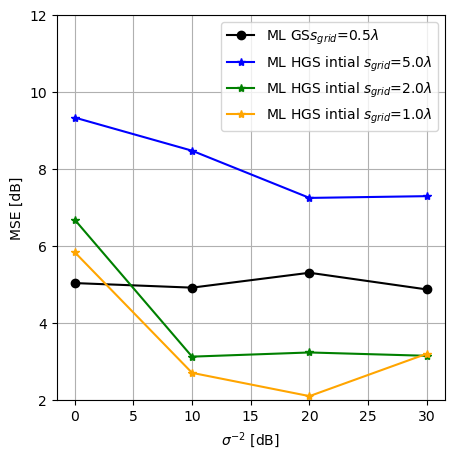

In [89]:
plt.figure()
plt.plot(noise_dB,ML_MSE_mean_dB[:,0],'o-',c='black')
color_list=['b','g','orange']
for i in range(len(ml2_resol)):
    plt.plot(noise_dB,ML2_MSE_mean_dB[:,i],'*-',c=color_list[i])

plt.legend([f'ML GS'+r'$s_{grid}$'+f'={ml_resol/lmb}'+r'$\lambda$',f'ML HGS intial '+r'$s_{grid}$'+f'={ml2_resol[0]/lmb}'+r'$\lambda$',f'ML HGS intial '+r'$s_{grid}$'+f'={ml2_resol[1]/lmb}'+r'$\lambda$',f'ML HGS intial '+r'$s_{grid}$'+f'={ml2_resol[2]/lmb}'+r'$\lambda$'])
plt.ylim([2,12])

plt.xlabel(r'$σ^{-2}$ [dB]')
plt.ylabel('MSE [dB]')
plt.grid()
plt.savefig(filepath+f'/Exp2_MSE_Result_ML_resol_{ml_resol/lmb}_lmb_ML2_{ml2_resol[0]/lmb}_{ml2_resol[1]/lmb}_{ml2_resol[2]/lmb}_lmb_ite_{HGS_itr_num}_reso_factor_{0.5}.png')
plt.savefig(filepath+f'/Exp2_MSE_Result_ML_resol_{ml_resol/lmb}_lmb_ML2_{ml2_resol[0]/lmb}_{ml2_resol[1]/lmb}_{ml2_resol[2]/lmb}_lmb_ite_{HGS_itr_num}_reso_factor_{0.5}.eps')

In [84]:
np.savetxt(filepath+'/Exp2_result_ML_MSE_mean_dB_lmb_ite_{HGS_itr_num}_reso_factor_{0.5}.txt',ML_MSE_mean_dB)
np.savetxt(filepath+'/Exp2_result_ML2_MSE_mean_dB_lmb_ite_{HGS_itr_num}_reso_factor_{0.5}.txt',ML2_MSE_mean_dB)
# np.savetxt(filepath+'/Exp2_result_ML_MSE_std.txt',ML_MSE_std)
# np.savetxt(filepath+'/Exp2_result_ML2_MSE_std.txt',ML2_MSE_std)

# Appendix track processing time

In [ ]:
#main 
def experiment(N,lmb,d,targets,noise_std,ml_resol,ssr_resol,flag_plot):
    # Array
    arr_dim=d*(N-1) # dimension of the array
    arr=array(N,arr_dim,0) # array elements location
    R_near=near_field_Boundary(lmb,arr_dim)
    arr_center=0.5*arr_dim
    time_ML=0
    time_SSR=0
    #Prepare arrays for results
    num_sam=5
    true_targets=np.empty([len(targets),num_sam,2])
    ML_targets=np.empty([len(targets),num_sam,2])
    SSR_targets=np.empty([len(targets),num_sam,2])  


    #begin experiment
    for i in range (len(targets)):
        if(i%10==0):
            print(i)
        
        for j in range(num_sam):
            true_targets[i,j]=targets[i]
            # phase measurements
            phase_obs=np.zeros(N)
            # phi_0=np.random.uniform(low=0,high=2*np.pi)#phase shift (offset, unknown constant)
            phi_0=1
#             print(f'phase shift is {phi_0}rad')

            dist=np.array([np.linalg.norm(arr[n]-true_targets[i,j]) for n in range(N)])#distance between the elements and target
            phase_obs=(4*np.pi/lmb*dist+phi_0+randn(N)*noise_std)%(2*np.pi)
            phase_shift=(4*np.pi/lmb*dist+phi_0)%(2*np.pi)
            phase_true=(4*np.pi/lmb*dist)%(2*np.pi)
            phase_true_unwrap=(4*np.pi/lmb*dist)

            if(flag_plot==1):
            #plot the phases
                plt.figure(figsize=(4,4))
                plt.scatter(range(1,N+1),phase_obs,color='red',s=size)
                plt.scatter(range(1,N+1),phase_shift,color='purple',s=size)
                plt.scatter(range(1,N+1),phase_true,color='green',s=size)
                plt.scatter(range(1,N+1),phase_true_unwrap,color='blue',s=size)
                plt.legend(['obs','shift','true','true unwrap'])
                plt.title('Target and array')
                plt.xlabel('x axis [Anetenna]')
                plt.ylabel('y axis [rad]')

            xrange=np.array([arr_center-R_near,arr_center+R_near])
            yrange=np.array([0,R_near])
            
            #ML
            T1=time.perf_counter()
            ml=ML();
            _,Loc_MLgrid=ml.ML_grid(xrange,yrange,phase_obs,arr,lmb,resolution=ml_resol,flag_plot=False)
            T2=time.perf_counter()
            time_ML+=(T2-T1)
        #     ml.plotting(size,f,targets,Loc_MLgrid,xrange,yrange)
            ML_targets[i,j]=Loc_MLgrid.reshape(2)

            #Unwrap + SSR
            T3=time.perf_counter()
            #Unwrap
            phase_u=Unwrap(phase_obs)
            if(flag_plot==1):
                #plot the unwrapped phases
                plt.figure(figsize=(4,4))
                plt.scatter(range(1,N+1),phase_obs,color='red',s=size)
                plt.scatter(range(1,N+1),phase_u,color='blue',s=size)
                plt.scatter(range(1,N+1),phase_true_unwrap,color='green',s=size)
                plt.legend(['obs phases','unwrapped phases','true unwrapped phases'],loc='upper left',fontsize=f)
                plt.title('Phase Unwrapping',fontsize=f)
                plt.ylim([min(phase_u),1.4*max(phase_true_unwrap)])
                plt.xlabel('x axis [Anetenna]',fontsize=f)
                plt.ylabel('y axis [rad]',fontsize=f)
            y=phase_u-phase_u[0]#observed phase differences (after unwrapping)
            q=arr
            q0=np.zeros([N,2])
            
            
            SR=sparse_recovery();
            p_candidate,best_each_y,loc_sparse = SR.SSR_1d(lmb,N,q,q0,xrange,yrange,ssr_resol,y)
            T4=time.perf_counter()
            time_SSR+=(T4-T3)
        #     SR.plotting(size,f,p_candidate,best_each_y,loc_sparse,targets,xrange,yrange,ssr_resol);
            SSR_targets[i,j]=loc_sparse.reshape(2)
    
    
    print(f'ML processing time per iteration:{time_ML/(len(targets)*num_sam)}')
    print(f'SSR processing time per iteration:{time_SSR/(len(targets)*num_sam)}')
    return true_targets,ML_targets,SSR_targets


In [ ]:
#group 1
noise_std=0.001
ml_resol=0.5*lmb;
ssr_resol=0.5*lmb;

true_targets,ML_targets,SSR_targets=experiment(N,lmb,d,targets[0:10],noise_std,ml_resol,ssr_resol,flag_plot)

ML_sl1,ML_std1=evaluate(true_targets,ML_targets)
SSR_sl1,SSR_std1=evaluate(true_targets,SSR_targets)
print(f'noise_std:{noise_std},resolution:{ml_resol/lmb}wavelength')
print(f'ML_mean_Squared_loss: {ML_sl1:.4}')
print(f'SSR_mean_Squared_loss: {SSR_sl1:.4}')
print(f'ML_std{ML_std1}')
print(f'SSR_std{SSR_std1}')

0


TypeError: ML.ML_grid() missing 1 required positional argument: 'flag_prior'

In [ ]:
#group 2 noise larger

noise_std=0.001
ml_resol=0.25*lmb;
ssr_resol=0.25*lmb;


true_targets,ML_targets,SSR_targets=experiment(N,lmb,d,targets[0:10],noise_std,ml_resol,ssr_resol,flag_plot)

ML_sl2,ML_std2=evaluate(true_targets,ML_targets)
SSR_sl2,SSR_std2=evaluate(true_targets,SSR_targets)
print(f'noise_std:{noise_std},resolution:{ml_resol/lmb}wavelength')
print(f'ML_mean_Squared_loss: {ML_sl2:.4}')
print(f'SSR_mean_Squared_loss: {SSR_sl2:.4}')
print(f'ML_std{ML_std2}')
print(f'SSR_std{SSR_std2}')

0
ML processing time per iteration:0.4048755280000023
SSR processing time per iteration:0.7755689900000039
noise_std:0.001,resolution:0.25wavelength
ML_mean_Squared_loss: 1.454e-06
SSR_mean_Squared_loss: 1.187e-06
ML_std[5.2e-04 8.1e-05]
SSR_std[0.00045192 0.00010125]
